# MLE Analysis of Bitcoin Data via PySATL-NMVM

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import mplfinance as mpf
from matplotlib import pyplot as plt
from scipy.stats import fit
from scipy.stats import genhyperbolic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from src.estimators.semiparametric.nmv_semiparametric_estimator import NMVSemiParametricEstimator
from src.estimators.semiparametric.nm_semiparametric_estimator import NMSemiParametricEstimator
from src.algorithms.semiparam_algorithms.nm_semi_param_algorithms.sigma_estimation_eigenvalue_based import SemiParametricMeanSigmaEstimationEigenvalueBased

Изначальные данные $-$ это сделки на бирже ByBit по торговой паре BTC/USDT за период 24.04.2025-24.05.2025. Всего наблюдений порядка $23\cdot10^6$

Данные были агрегированные в бары по 10000\$, из каждого выписаны основные показатели:
- $open$: цена открытия первой сделки в баре
- $close$: цена закрытия последней сделки в баре
- $low$: минимальная стоимость биткоина среди всех сделок в баре
- $high$: максимальная стоимость биткоина среди всех сделок в баре
- $volume$: суммарный объем сделок в баре
- $legth$: количество сделок в баре

На основе нового датасета добавлен ещё один столб:
- $h_n$: возврат - разница между ценами закрытия $n$-ой и $(n-1)$-ой сделками

В новом датасете получилось около $33\cdot10^3$ наблюдений


In [3]:
df = pd.read_csv("data/bitcoin_example.csv", index_col="bar")
df['hn'] = df['close'] - df['close'].shift(1)
df.loc[0, 'hn'] = 0

In [4]:
df.head()

,open,close,low,high,volume,length,timestamp,hn
bar,,,,,,,,
0,93741.6,93739.7,93739.7,93795.2,10.594618,1651,2025-04-28,0.0
1,93739.6,93696.1,93696.0,93739.6,10.710546,718,2025-04-28,-43.6
2,93696.1,93676.1,93664.9,93738.7,10.681198,1603,2025-04-28,-20.0
3,93676.1,93667.8,93667.8,93703.7,10.564766,1359,2025-04-28,-8.3
4,93667.8,93510.0,93510.0,93667.9,10.797982,1713,2025-04-28,-157.8


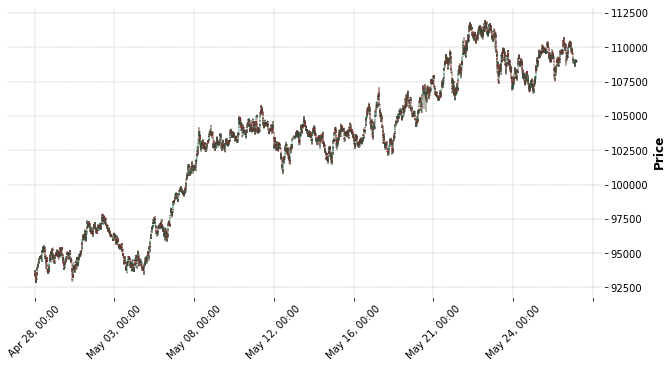

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
candles = df.set_index('timestamp')
mpf.plot(candles, type='candle', style='charles', ylabel='Price', volume=False, figratio=(12, 6), warn_too_much_data=34000)

Построим график плотности возвратов

Text(0, 0.5, 'density')

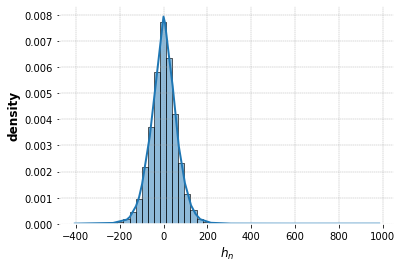

In [6]:
sns.histplot(df.hn, kde=True, bins=50, stat='density')
plt.xlabel('$h_n$')
plt.ylabel('density')

На графике видны полутяжёлые хвосты (есть выбросы). 
Сильный подъём, острый пик в районе нулей. Если распределение непрерывное, нужно проверить, что ноль встречается не более одного раза

In [7]:
(df['hn'] == 0.0).sum()

np.int64(264)

Text(0, 0.5, 'density')

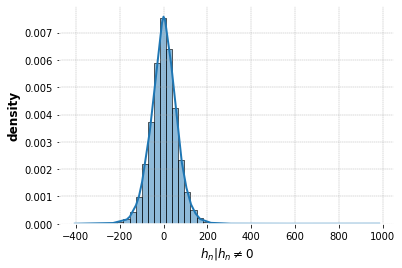

In [8]:
sample = df[df.hn != 0.0].hn
    
sns.histplot(sample, kde=True, bins=50, stat='density')
plt.xlabel('$h_n|h_n\\neq 0$')
plt.ylabel('density')

Наблюдается очень острая форма, не похожая на нормальное распределение. Посмотрим на структуру зависимости второго порядка

Text(0, 0.5, 'correlation')

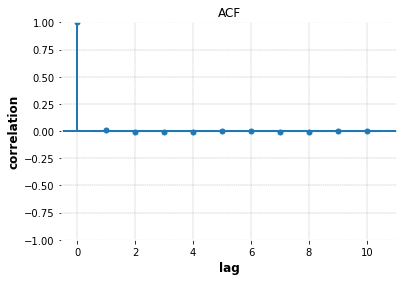

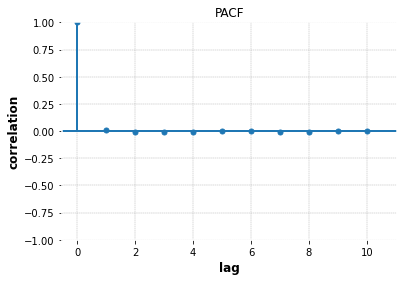

In [9]:
plot_acf(sample, lags=10)
plt.title('ACF')
plt.xlabel("lag")
plt.ylabel("correlation")

plot_pacf(sample, lags=10)
plt.title('PACF')
plt.xlabel("lag")
plt.ylabel("correlation")

Зависимости (явной) от прошлого не наблюдается.
Не наблюдая линейной зависимости, можно предположить слабую зависимость

## Использование моделей нормальных смесей

Попробуем применить методы из пакета

### Нормальная смесь дисперсии среднего

$Y_{NMVM}(\xi, \alpha, \mu)=\alpha+\mu\cdot\xi+\sqrt{\xi}\cdot N$

Параметр $\alpha$ равен моде данных, что в нашем случае равняется 0.0

$\mu$ надо оценить

Text(0, 0.5, 'size')

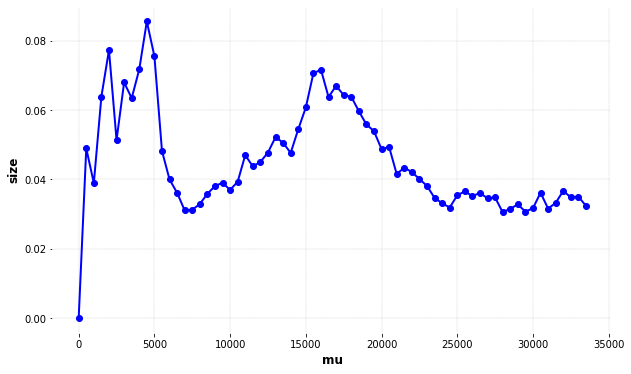

In [10]:
ESTIMATOR_PARAMS_MU = {
    "m": 20,
    "tolerance": 1e-5,
}

SAMPLE_SIZES = range(1, 33983, 500)
results_mu = dict()
estimator = NMVSemiParametricEstimator("mu_estimation", ESTIMATOR_PARAMS_MU)
for n in SAMPLE_SIZES:
    sample = df.hn[:n]
    estimate_result = estimator.estimate(sample)
    results_mu[n] = estimate_result.value
plt.figure(figsize=(10, 6))
plt.plot(results_mu.keys(), results_mu.values(),
         marker='o', linestyle='-', color='b', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("mu")
plt.ylabel("size")

In [11]:
mu = estimator.estimate(sample).value
mu

0.03237192519009113

Учитывая визуальную форму распределения и то, что мода равна нулю, можем:
- предположить, что маргинальное распределение $h_n | h_n\neq0$ относится к классу обобщенных гиперболических распределений 
- использовать полученное значение $\mu$ в качестве начальноого приблежения для MLE оценки в данном классе

In [12]:
sample = df[df.hn != 0.0].hn
p, a, b, loc, scale = genhyperbolic.fit(sample, 3, mu*1.1, mu)

Text(0, 0.5, '$h_n$')

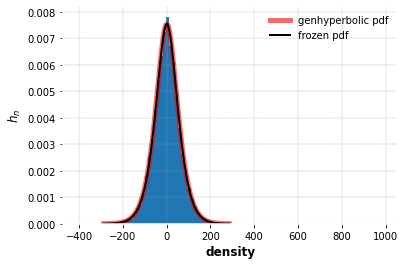

In [13]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(genhyperbolic.ppf(0.0001, p, a, b, loc, scale),
                genhyperbolic.ppf(0.9999, p, a, b, loc, scale), 100)
ax.plot(x, genhyperbolic.pdf(x, p, a, b, loc, scale), 'r-', lw=5, alpha=0.6, label='genhyperbolic pdf')
rv = genhyperbolic(p, a, b, loc, scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = genhyperbolic.ppf([0.001, 0.5, 0.999], p, a, b, loc, scale)
np.allclose([0.001, 0.5, 0.999], genhyperbolic.cdf(vals, p, a, b, loc, scale))
ax.hist(sample, density=True, bins=100)
ax.legend(loc='best', frameon=False)
plt.xlabel("density")
plt.ylabel("$h_n$")

Выводы: 
- визуально модель неплохо описывает данные
- нужно понять, как учитывать выбросы в таких моделях

### Нормальная смесь средних

$Y_{NMM}(\xi, \sigma)=\xi+\sigma\cdot N$

Нужно вычислить $\sigma$

Text(0.5, 1.0, 'Матрица значений сигмы для разных параметров l и k')

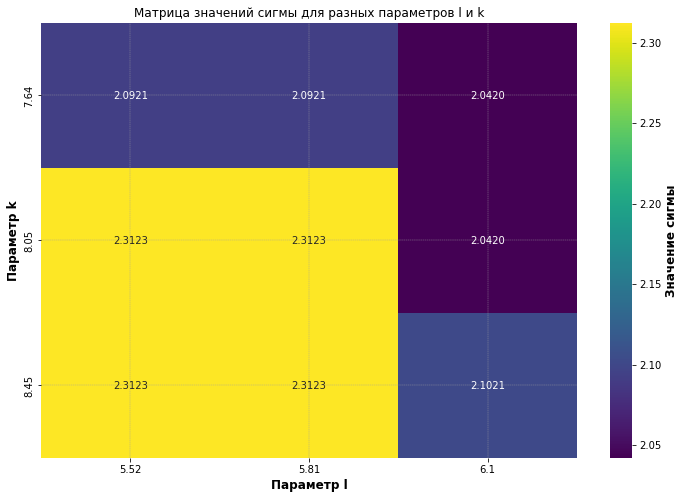

In [14]:
n = len(sample)
a = 0.1
b = 0.2
s = 1
v_n = np.sqrt(np.log(np.log(n)))

k_0 = n**(1/2 - a - b)
l_0 = k_0 * 1/s * np.sqrt(a*np.log(n) / 2)
eps = np.sqrt(2*a)/s * np.sqrt(np.log(n))/n**b * v_n

k_values = [0.95*k_0, k_0, k_0 * 1.05]
l_values = [0.95*l_0, l_0, l_0 * 1.05]

sigma_matrix = np.zeros((len(k_values), len(l_values)))

for i, k in enumerate(k_values):
    for j, l in enumerate(l_values):
        try:
            estimator = SemiParametricMeanSigmaEstimationEigenvalueBased(
                sample=sample,
                l=float(l),
                k=float(k),
                eps=eps,
                search_area=10.0,
                search_density=1000
            )
            result = estimator.algorithm(sample)
            sigma_matrix[i, j] = result.value if result.success else np.nan
        except:
            sigma_matrix[i, j] = np.nan

plt.figure(figsize=(12, 8))
sns.heatmap(
    sigma_matrix,
    annot=True,
    fmt=".4f",
    xticklabels=np.round(l_values, 2),
    yticklabels=np.round(k_values, 2),
    cmap="viridis",
    cbar_kws={'label': 'Значение сигмы'}
)
plt.xlabel("Параметр l")
plt.ylabel("Параметр k")
plt.title("Матрица значений сигмы для разных параметров l и k")

Можно было бы сравнить с методом на основании Лапласа. Но он пока не работает. См. [issue](https://github.com/PySATL/pysatl-nmvm/issues/57)

In [15]:
x = np.linspace(-10, 10, 500)
estimator = NMSemiParametricEstimator("g_estimation_convolution", {"x_data": x, "sigma": 2.0})
result = estimator.estimate(sample.values)

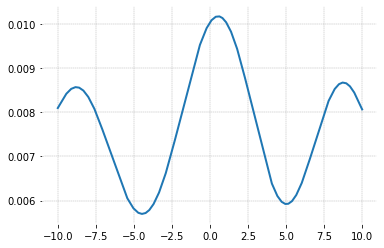

In [16]:
plt.plot(x, result.list_value)

Эта оценка не похожа на правдивую. Если прикинуть, то вероятность попасть в интервал от -10 до 10 равна 0.14 и это очень мало.

Два варианта почему так:
- мало данных и такой результат ожидаем, потому что у такой оценки скорость схождения $\frac{1}{\sqrt{\log(n)}}$
- модель плохо описывает данные.

В любом случе без дополнительных предположений ничего сказать не можем. Распределение явно не угадывается